# Diffusion Simulation on PyTorch


Copyright (c) 2018 Lirimy  
Released under the MIT license  
http://opensource.org/licenses/mit-license.php

In [18]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation
%matplotlib inline

import torch
import torch.nn as nn
from torch.autograd import Variable


In [2]:
#dtype = torch.FloatTensor # CPU
dtype = torch.cuda.FloatTensor # GPU

In [65]:
class Net(nn.Module):
    
    def __init__(self, sigma=3.):
        super(Net, self).__init__()
        
        self.setSigma(sigma)
        self.setGrid(np.random.randn(60,80))
    
    def setSigma(self, sigma=3.):
        """
        set sigma and automatically generate transpose tensor
        sigma: float-like (default: 3.)
        """
        self.sigma=sigma
        m = int(min(64-1, norm.ppf(0.99, scale=sigma)))
        self.m = m
        ruler = np.linspace(-m, m, num=2*m+1, endpoint=True)
        X1, X2 = np.meshgrid(ruler, ruler)
        dist = norm.pdf(np.sqrt(X1*X1+X2*X2), scale=sigma)
        dist = dist / dist.sum()

        self.conv = nn.Conv2d(1, 1, 2*m+1, padding=m, bias=False)
        self.conv.weight = nn.Parameter(torch.Tensor([[dist]]).type(dtype),
                                        requires_grad=False)
    
    def getSigma(self):
        """
        get sigma
        return: float-like
        """
        return self.sigma
    
    def getWeight(self):
        """
        get transpose matrix
        return: Numpy 2-D Array
        """
        return self.conv.weight.data.cpu().numpy()[0, 0]
    
    def setGrid(self, x):
        """
        set grid value
        x: Numpy 2-D Array
        """
        self.gridMin = min(0, x.min())
        self.gridMax = max(0, x.max())
        self.grid = Variable(torch.Tensor([[x]]).type(dtype),
                             requires_grad=False)
        
    def getGrid(self):
        """
        get grid value
        return: Numpy 2-D Array
        """
        return self.grid.data.cpu().numpy()[0, 0]
    
    def step(self):
        """
        update grid by convolution of weight
        """
        self.grid = self.conv(self.grid)
    
    def showGrid(self, autoscale=False, colorbar=True, nocbtick=False,
                 notick=True):
        """
        show grid
        return: matplotlib object
        """
        fig, ax = plt.subplots()
        self.fig = fig
        self.ax = ax
        
        if autoscale:
            im = ax.pcolormesh(self.getGrid())
        else:
            im = ax.pcolormesh(self.getGrid(),
                           vmin=self.gridMin, vmax=self.gridMax)
        
        ax.axis("image")
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad="3%")
        
        if colorbar:
            if nocbtick:
                fig.colorbar(im, cax=cax).ax.tick_params(\
                                labelright='off', right='off')
            else:
                fig.colorbar(im, cax=cax)
        
        if notick:
            ax.tick_params(labelbottom='off', labelleft='off')
            ax.tick_params(bottom='off', left='off')
        
        self.im = im
        return im
    
    def updateAnim(self, frame):
        """
        for FuncAnimation
        call showGrid before updateAnim
        
        frame: number of frame
        return: im
        """
        self.im.set_array(self.getGrid().ravel())
        self.step() # After set to show the first state
        return self.im
    

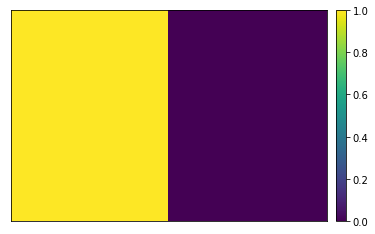

In [67]:
# Initialize Grid

net = Net(3.)

gridsize = (200, 300)

ini = np.zeros(gridsize)
ini[:, :gridsize[1]//2] = 1.

net.setGrid(ini)

net.showGrid()

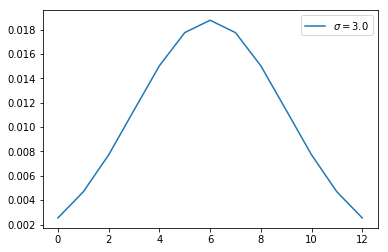

In [33]:
# Weight

net.setSigma(3.)

plt.plot(net.getWeight()[net.m])
plt.legend(["$\sigma=$" + str(net.getSigma())])
plt.show()

CPU times: user 370 ms, sys: 157 ms, total: 527 ms
Wall time: 527 ms


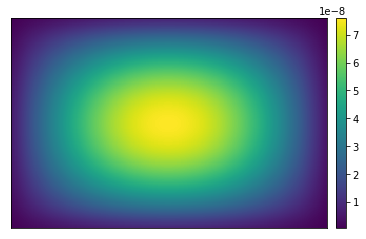

In [79]:
%%time

# Diffusion

numLoop = 100

for _ in range(numLoop):
    net.step()

net.showGrid(autoscale=True)

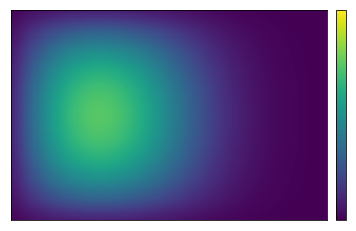

In [68]:
# Animation

net = Net(10)

gridsize = (200, 300)

ini = np.zeros(gridsize)
ini[:, :gridsize[1]//2] = 1.
net.setGrid(ini)

net.showGrid(nocbtick=True)
anim = FuncAnimation(net.fig, net.updateAnim,
                     blit=False, interval=100, frames=30)

#anim.save("anim.gif", writer="imagemagick", fps=10)
anim.save("anim.mp4", writer="ffmpeg", fps=10)